In [1]:
import os
import zipfile
import cv2
from glob import glob
import numpy as np
from zipfile import ZipFile
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer, Dropout, Flatten, Conv2D, MaxPool2D,Activation,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop

from tabulate import tabulate

## Importing Data

In [2]:
plant_seedling_zip = "plant-seedlings-classification.zip"

In [3]:
!mkdir plant_seedling_data_directory

In [4]:
with ZipFile(plant_seedling_zip, 'r') as zip:
    zip.extractall('./plant_seedling_data_directory')

In [5]:
path = "./plant_seedling_data_directory/train/*/*.png"
image_size = 128

print("Starting to gather image file paths.")
files = glob(path)

print(f"Found {len(files)} image files.")


print("Reading and resizing images.")
training_images = [cv2.resize(cv2.imread(img), (image_size, image_size)) for img in files]

print("Extracting labels.")
training_label = [os.path.basename(os.path.dirname(img)) for img in files]

print("Converting lists to NumPy array and Pandas DataFrame.")

training_images = np.asarray(training_images)
training_label = pd.DataFrame(training_label, columns=['label'])

print("Image and label data preparation complete.")

Starting to gather image file paths.
Found 4750 image files.
Reading and resizing images.
Extracting labels.
Converting lists to NumPy array and Pandas DataFrame.
Image and label data preparation complete.


## Exploratory Data Analysis

In [6]:
print(f'Images shape: {training_images.shape}')
print(f'Labels shape: {training_label.shape}')

Images shape: (4750, 128, 128, 3)
Labels shape: (4750, 1)


In [7]:
label_counts = training_label['label'].value_counts()

In [8]:
label_counts

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: label, dtype: int64

In [9]:
def plot_plant_distribution(labels):

    labels_df = pd.DataFrame(labels, columns=['label'])
    
    label_counts = labels_df['label'].value_counts()
    
    num_categories = len(label_counts)
    colors = plt.get_cmap('Greens')(np.linspace(0.3, 0.7, num_categories))
    
    plt.figure(figsize=(12, 8))
    plt.bar(label_counts.index, label_counts.values, color=colors)
    plt.xlabel('Plant Category')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Plant Categories')
    plt.xticks(rotation=90)  
    plt.tight_layout()
    plt.show()

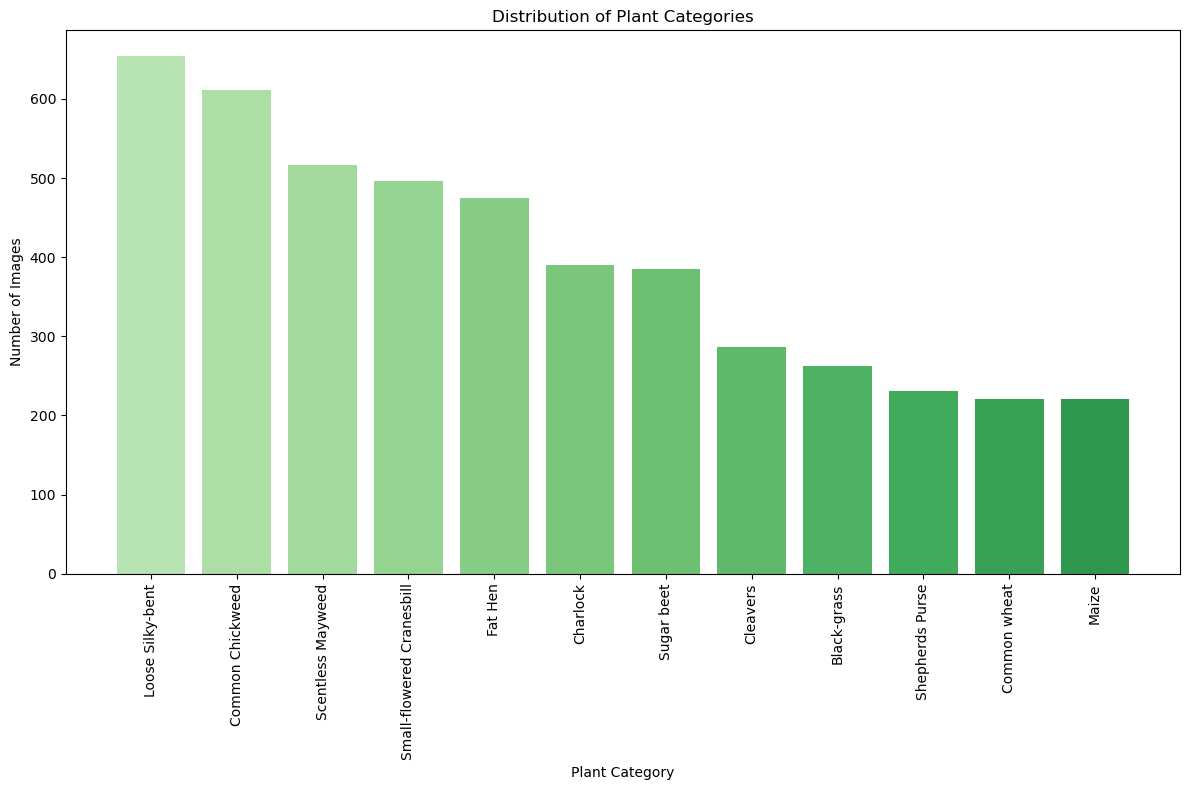

In [10]:
plot_plant_distribution(training_label['label'])

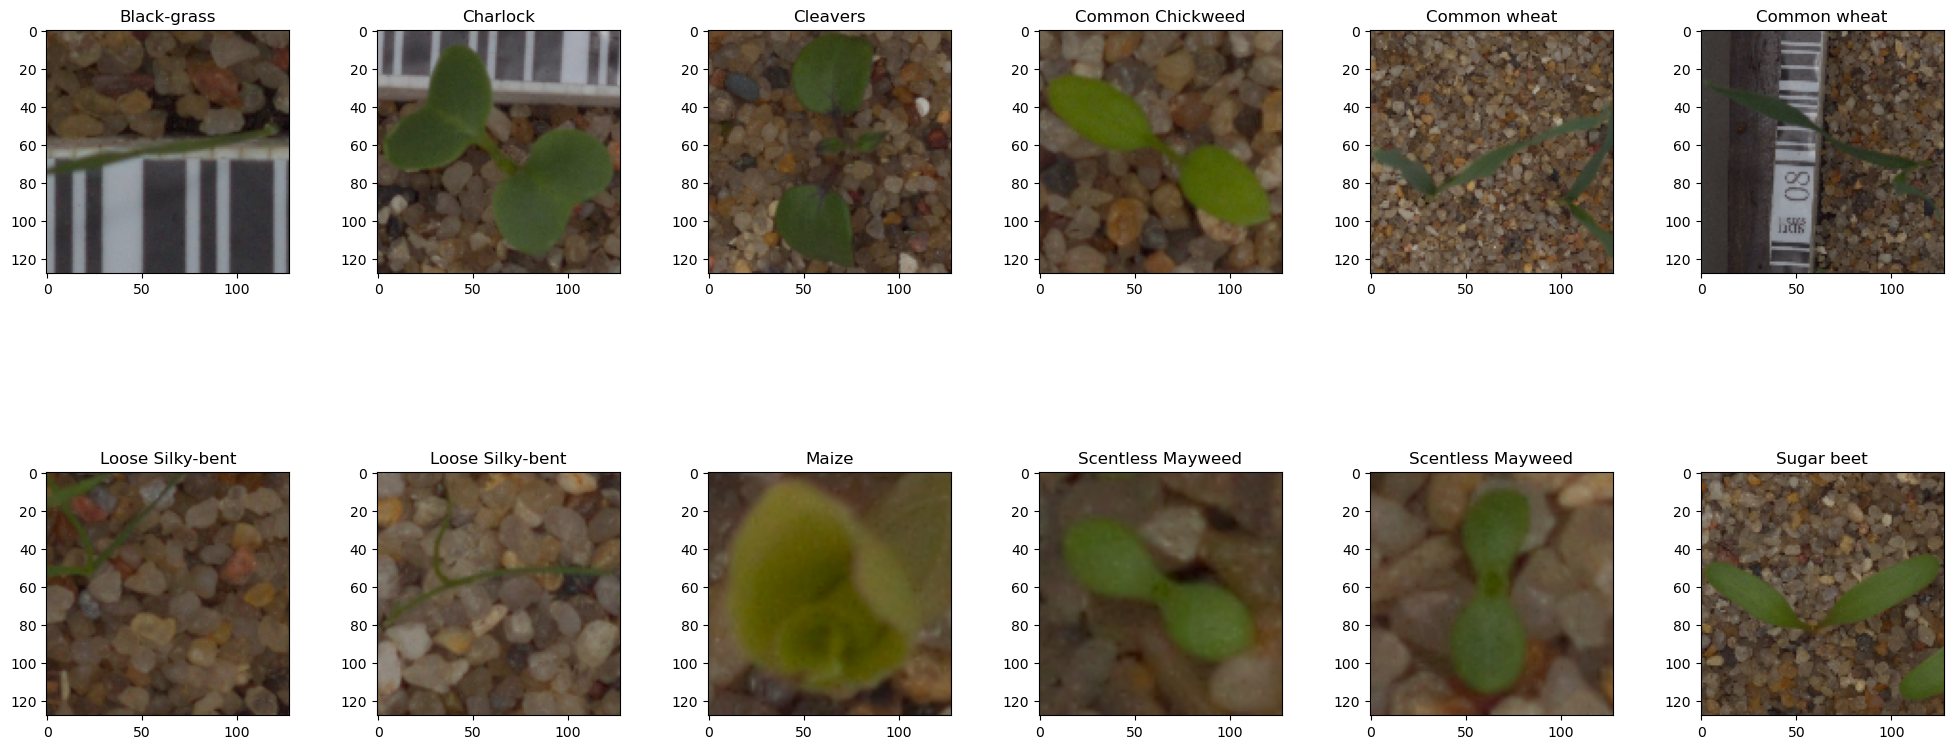

In [11]:
plot = plt.figure(figsize=(20, 20))

plot.add_subplot(2, 6, 1)
plt.imshow(cv2.cvtColor(training_images[0], cv2.COLOR_BGR2RGB))  
plt.title(training_label.iloc[0, 0])  

plot.add_subplot(2, 6, 2)
plt.imshow(cv2.cvtColor(training_images[496], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[496, 0])

plot.add_subplot(2, 6, 3)
plt.imshow(cv2.cvtColor(training_images[759], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[759, 0])

plot.add_subplot(2, 6, 4)
plt.imshow(cv2.cvtColor(training_images[1370], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[1370, 0])

plot.add_subplot(2, 6, 5)
plt.imshow(cv2.cvtColor(training_images[1755], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[1755, 0])

plot.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(training_images[1685], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[1685, 0])

plot.add_subplot(1, 6, 1)
plt.imshow(cv2.cvtColor(training_images[2409], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[2409, 0])

plot.add_subplot(1, 6, 2)
plt.imshow(cv2.cvtColor(training_images[2630], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[2630, 0])

plot.add_subplot(1, 6, 3)
plt.imshow(cv2.cvtColor(training_images[3020], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[3020, 0])

plot.add_subplot(1, 6, 4)
plt.imshow(cv2.cvtColor(training_images[3251], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[3251, 0])

plot.add_subplot(1, 6, 5)
plt.imshow(cv2.cvtColor(training_images[3538], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[3538, 0])

plot.add_subplot(1, 6, 6)
plt.imshow(cv2.cvtColor(training_images[4749], cv2.COLOR_BGR2RGB))
plt.title(training_label.iloc[4749, 0])

plt.tight_layout()
plt.show()

## Image Preprocessing

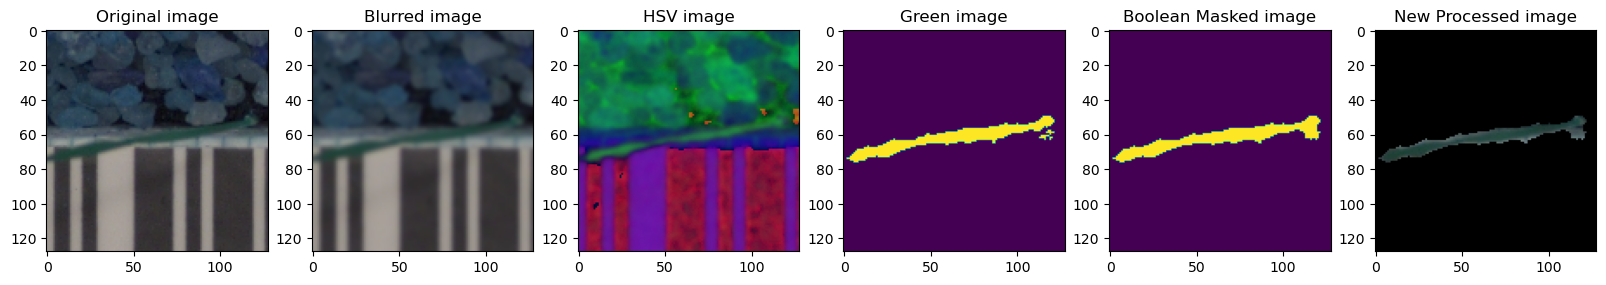

In [12]:
processed_images = []
sets = []; 
example = True

for i in training_images:
    
    blurred_image = cv2.GaussianBlur(i, (5, 5), 0)

    hsv_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    green_lower_range = (25, 40, 50)
    green_upper_range = (75, 255, 255)
    
    green_mask = cv2.inRange(hsv_image,green_lower_range,green_upper_range)
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(green_mask,cv2.MORPH_CLOSE,structuring_element)
    
    boolean_image = mask>0
    
    new_image = np.zeros_like(i,np.uint8)
    new_image[boolean_image] = i[boolean_image]
    
    processed_images.append(new_image)
    
    if example:
        plot = plt.figure(figsize=(20, 20))
        plot.add_subplot(1,6,1);plt.imshow(i);plt.title('Original image') 
        plot.add_subplot(1,6,2);plt.imshow(blurred_image);plt.title('Blurred image') 
        plot.add_subplot(1,6,3);plt.imshow(hsv_image);plt.title('HSV image') 
        plot.add_subplot(1,6,4);plt.imshow(green_mask);plt.title('Green image') 
        plot.add_subplot(1,6,5);plt.imshow(boolean_image);plt.title('Boolean Masked image') 
        plot.add_subplot(1,6,6);plt.imshow(new_image);plt.title('New Processed image') 
        example = False
        
processed_images = np.asarray(processed_images)

In [13]:
processed_images.shape

(4750, 128, 128, 3)

In [14]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(training_label['label'])
print('Classes: ' + str(label_encoder.classes_))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [15]:
encodedlabel = label_encoder.transform(training_label['label'])

convertedlabels = to_categorical(encodedlabel)
classes = convertedlabels.shape[1]
print(str(classes))

12


In [16]:
convertedlabels[500]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
processed_images = processed_images.astype('float32') / 255.0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    processed_images,       
    convertedlabels,       
    test_size=0.3,         
    random_state=42,        
    stratify=convertedlabels  
)

In [19]:
X_val,X_test_new,y_val,y_test_new = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=42,
    stratify=y_test)

In [20]:
generator = ImageDataGenerator(rotation_range = 180,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True)
generator.fit(X_train)

## Modelling 

In [21]:
model = Sequential()

model.add(InputLayer(input_shape=(image_size,image_size,3,)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
 
model.add(MaxPool2D(pool_size = (2,2)))

model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(GlobalMaxPool2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(BatchNormalization())

model.add(Dense(12, activation='softmax'))

model.summary()

C:\Users\ramsh\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 286,988 (1.09 MB)

 Trainable params: 286,348 (1.09 MB)

 Non-trainable params: 640 (2.50 KB)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(generator.flow(X_train,y_train,batch_size=64),epochs=100, verbose=2,shuffle=True,validation_data=(X_val,y_val))
pd.DataFrame(history.history)

Epoch 1/100


C:\Users\ramsh\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 - 68s - 1s/step - accuracy: 0.2941 - loss: 2.1452 - val_accuracy: 0.1868 - val_loss: 2.5824
Epoch 2/100
52/52 - 53s - 1s/step - accuracy: 0.5326 - loss: 1.3850 - val_accuracy: 0.0604 - val_loss: 3.0009
Epoch 3/100
52/52 - 59s - 1s/step - accuracy: 0.6352 - loss: 1.1125 - val_accuracy: 0.0604 - val_loss: 3.6959
Epoch 4/100
52/52 - 50s - 957ms/step - accuracy: 0.7071 - loss: 0.8985 - val_accuracy: 0.0604 - val_loss: 4.0156
Epoch 5/100
52/52 - 58s - 1s/step - accuracy: 0.7383 - loss: 0.7865 - val_accuracy: 0.0604 - val_loss: 4.8170
Epoch 6/100
52/52 - 72s - 1s/step - accuracy: 0.7792 - loss: 0.6663 - val_accuracy: 0.0618 - val_loss: 4.1323
Epoch 7/100
52/52 - 66s - 1s/step - accuracy: 0.7988 - loss: 0.6085 - val_accuracy: 0.0604 - val_loss: 5.4410
Epoch 8/100
52/52 - 59s - 1s/step - accuracy: 0.8123 - loss: 0.5554 - val_accuracy: 0.0632 - val_loss: 5.0834
Epoch 9/100
52/52 - 59s - 1s/step - accuracy: 0.8289 - loss: 0.5152 - val_accuracy: 0.1180 - val_loss: 3.6980
Epoch 10/100
52/52 

Epoch 75/100
52/52 - 56s - 1s/step - accuracy: 0.9540 - loss: 0.1243 - val_accuracy: 0.8904 - val_loss: 0.3196
Epoch 76/100
52/52 - 57s - 1s/step - accuracy: 0.9519 - loss: 0.1286 - val_accuracy: 0.8624 - val_loss: 0.4520
Epoch 77/100
52/52 - 57s - 1s/step - accuracy: 0.9395 - loss: 0.1582 - val_accuracy: 0.8890 - val_loss: 0.3519
Epoch 78/100
52/52 - 57s - 1s/step - accuracy: 0.9498 - loss: 0.1348 - val_accuracy: 0.7556 - val_loss: 0.7252
Epoch 79/100
52/52 - 56s - 1s/step - accuracy: 0.9489 - loss: 0.1410 - val_accuracy: 0.8792 - val_loss: 0.4063
Epoch 80/100
52/52 - 56s - 1s/step - accuracy: 0.9516 - loss: 0.1187 - val_accuracy: 0.9045 - val_loss: 0.3379
Epoch 81/100
52/52 - 56s - 1s/step - accuracy: 0.9465 - loss: 0.1380 - val_accuracy: 0.8062 - val_loss: 0.5571
Epoch 82/100
52/52 - 57s - 1s/step - accuracy: 0.9495 - loss: 0.1337 - val_accuracy: 0.8975 - val_loss: 0.2880
Epoch 83/100
52/52 - 56s - 1s/step - accuracy: 0.9534 - loss: 0.1335 - val_accuracy: 0.9087 - val_loss: 0.2934
E

,accuracy,loss,val_accuracy,val_loss
0,0.294135,2.145223,0.186798,2.582406
1,0.532632,1.384972,0.060393,3.000871
2,0.635188,1.112495,0.060393,3.695919
3,0.707068,0.898460,0.060393,4.015595
4,0.738346,0.786512,0.060393,4.817036
...,...,...,...,...
95,0.955188,0.116101,0.837079,0.508877
96,0.953684,0.120266,0.886236,0.336215
97,0.955188,0.117882,0.848315,0.477039
98,0.956391,0.123754,0.789326,0.644768


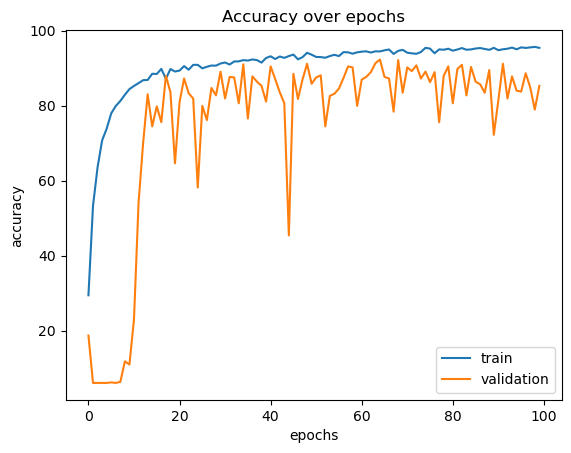

In [23]:
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [24]:
scores = model.evaluate(X_test_new, y_test_new)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8285 - loss: 0.5456
Test loss: 0.4985930621623993
Test accuracy: 0.8401122093200684


## Evaluation 

In [25]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


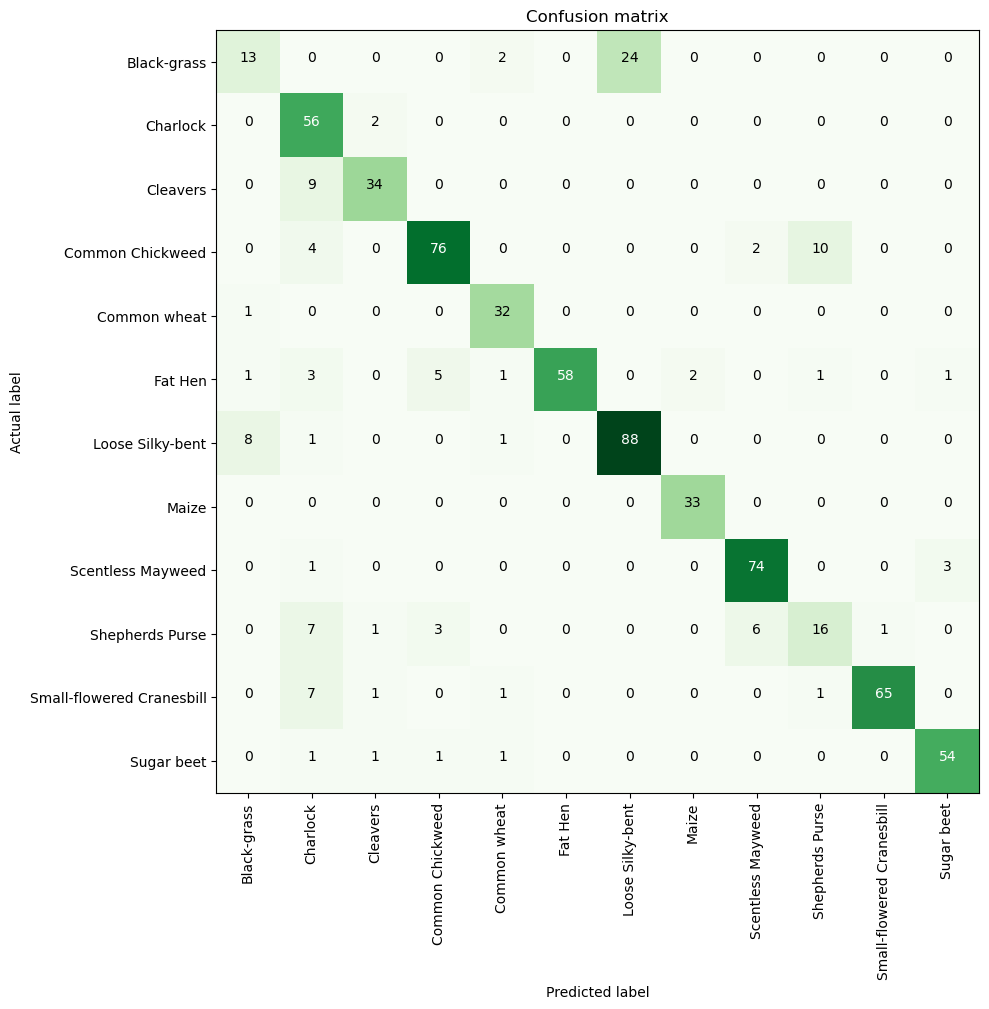

In [26]:
y_pred = model.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test_new, axis = 1) 

confusionMTX = confusion_matrix(trueY, y_pred_Classes) 

plot_confusion_matrix(confusionMTX, classes = label_encoder.classes_)

In [27]:
score_test, accuracy_test = model.evaluate(X_test_new,y_test_new)
score_train, accuracy_train = model.evaluate(X_train,y_train)
print('Testing score:', score_test,'   Test accuracy:', accuracy_test)
print('Training score:', score_train,'   Train accuracy:',accuracy_train)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8285 - loss: 0.5456
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.9019 - loss: 0.2960
Testing score: 0.4985930621623993    Test accuracy: 0.8401122093200684
Training score: 0.3179435729980469    Train accuracy: 0.8980451226234436


## Testing out the model on seed images without labels

In [38]:
test_images_path = "./plant_seedling_data_directory/test/*.png"

testing_data_images = glob(test_images_path)
testing_data_images_arr = []
test_file_images = []

for img in testing_data_images:
    testing_data_images_arr.append(cv2.resize(cv2.imread(img), (128, 128)))
    test_file_images.append(img.split('/')[-1])

test_X = np.asarray(testing_data_images_arr)

test_X = test_X.astype('float32') / 255

In [39]:
predictions = model.predict(test_X)
preds = np.argmax(predictions, axis=1)
predicted_label = label_encoder.classes_[preds]

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [40]:
prediction_data = {'Image Name': test_file_images, 'Label': predicted_label}
predictions_df = pd.DataFrame(prediction_data)

In [43]:
print(tabulate(prediction_data, headers='keys', tablefmt='pretty'))

+--------------------+---------------------------+
|     Image Name     |           Label           |
+--------------------+---------------------------+
| test\0021e90e4.png | Small-flowered Cranesbill |
| test\003d61042.png |        Sugar beet         |
| test\007b3da8b.png |        Black-grass        |
| test\0086a6340.png |     Common Chickweed      |
| test\00c47e980.png |        Sugar beet         |
| test\00d090cde.png |        Sugar beet         |
| test\00ef713a8.png |     Common Chickweed      |
| test\01291174f.png |          Fat Hen          |
| test\026716f9b.png |        Sugar beet         |
| test\02cfeb38d.png |        Sugar beet         |
| test\03566743d.png |         Charlock          |
| test\03a2ee656.png |         Charlock          |
| test\03e322a29.png |        Sugar beet         |
| test\03ef36742.png |        Sugar beet         |
| test\043449b0b.png |        Sugar beet         |
| test\0437393b1.png |          Fat Hen          |
| test\04814f36d.png |     Scen

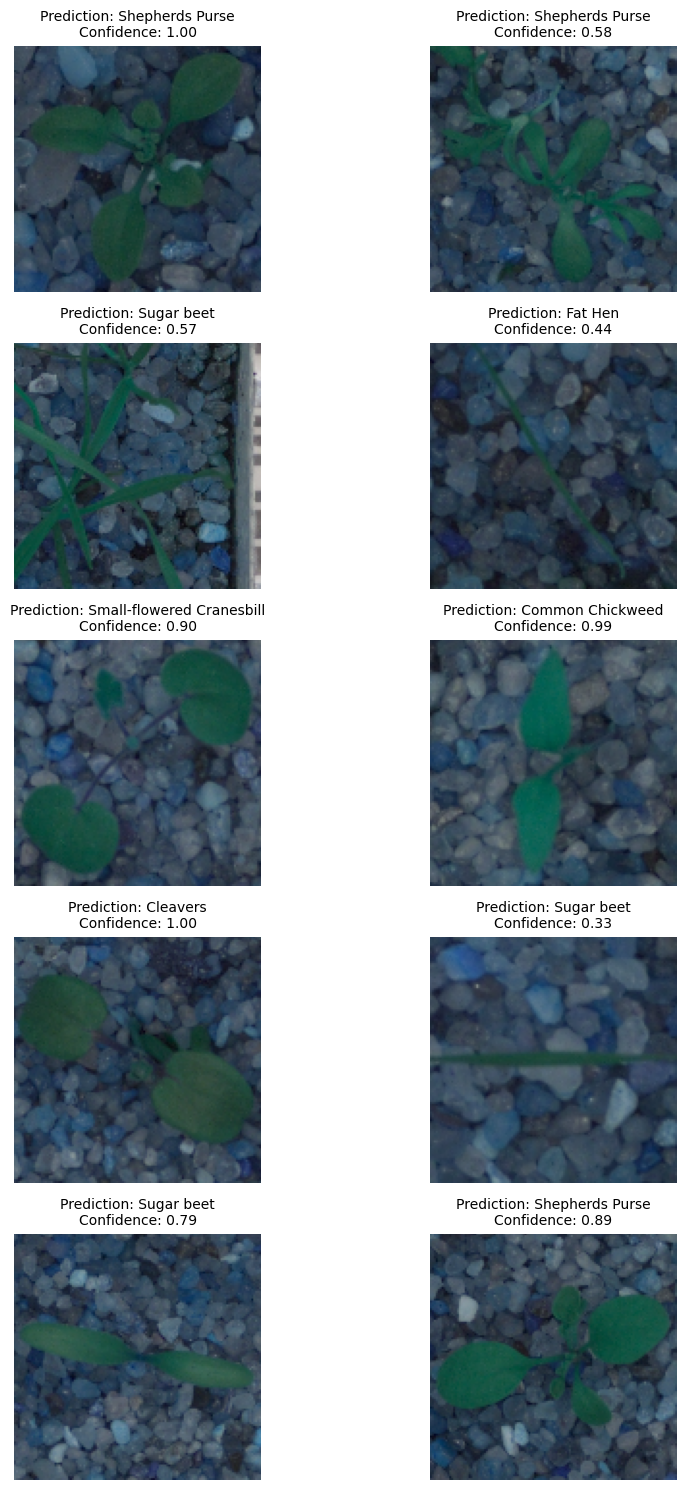

In [41]:
num_images = 10

indices = np.random.choice(len(test_X), num_images, replace=False)

cols = 2  
rows = (num_images + cols - 1) // cols  
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

axes = axes.flatten()

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.imshow(test_X[idx])
    confidence = np.max(predictions[idx])
    ax.set_title(f'Prediction: {predicted_label[idx]}\nConfidence: {confidence:.2f}', fontsize=10)
    ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()